In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from scipy.optimize import curve_fit as cf
from sklearn import preprocessing as prep


In [3]:
c = 299792458
h = 6.626e-34
kB = 1.38e-23
T = 8
gs = 63e9
boltzmann = np.exp(-h*gs/(kB*T))
boltzmann

0.6851522994735559

In [48]:
Gamma_pht = 1/(2*np.pi*3.4)
Gamma_phn = 1/(2*np.pi*100)
Gamma_spin = 1/(2*np.pi*1e4)

eta = 0.25
OmegaC3 = np.sqrt(6000*0.1/10)/2*Gamma_pht
OmegaC1 = OmegaC3*np.sqrt(eta)*9
print(OmegaC3, OmegaC1)

0.18129542472397056 0.8158294112578676


In [43]:
a1 = basis(5,0)
a2 = basis(5,1)
b1 = basis(5,2)
b2 = basis(5,3)
c = basis(5,4)

HintC1 = OmegaC1/2*(a1*c.dag() + c*a1.dag()) 
HintC3 = OmegaC3/2*(a2*c.dag() + c*a2.dag())

Gamma_c = np.sqrt(Gamma_pht)*(eta*(b1+a1)+b2+a2)*c.dag()

Gamma_a1 = (np.sqrt(Gamma_spin)*a2 + (np.sqrt(boltzmann*Gamma_phn)*b2 + np.sqrt(boltzmann*Gamma_phn)*b1))*a1.dag()
Gamma_a2 = (np.sqrt(Gamma_spin)*a1 + (np.sqrt(boltzmann*Gamma_phn)*b1 + np.sqrt(boltzmann*Gamma_phn)*b2))*a2.dag()

Gamma_b1 = (np.sqrt(Gamma_spin)*b2+(np.sqrt(eta*Gamma_phn)*a2 + np.sqrt(Gamma_phn)*a1))*b1.dag()
Gamma_b2 = (np.sqrt(Gamma_spin)*b1+(np.sqrt(eta*Gamma_phn)*a1 + np.sqrt(Gamma_phn)*a2))*b2.dag()

c_ops = [Gamma_c, Gamma_a1, Gamma_a2, Gamma_b1, Gamma_b2]

def seqC3(t, args):    
    return np.where( (t>args['tstart']) & (t<args['tstart']+args['pulsewidth']), 1, 0)
    

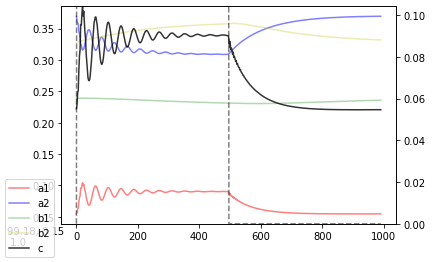

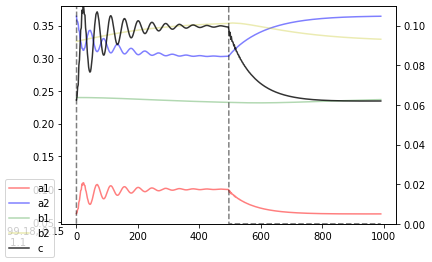

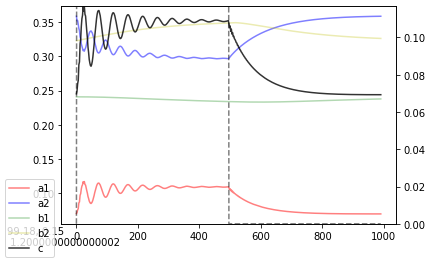

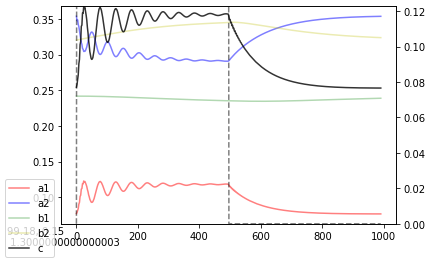

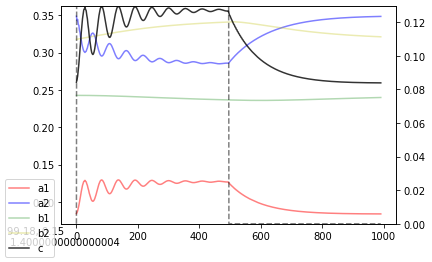

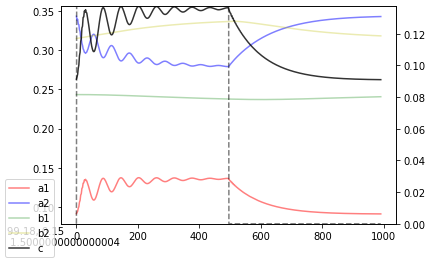

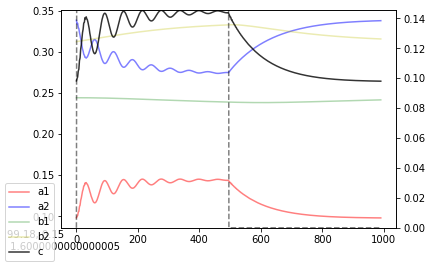

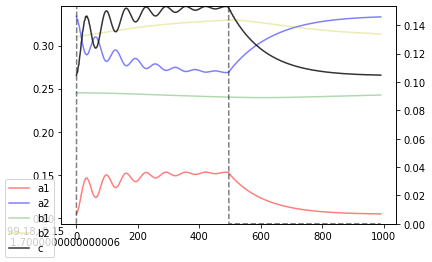

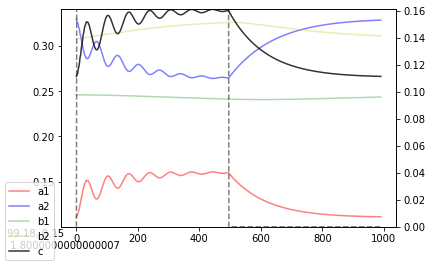

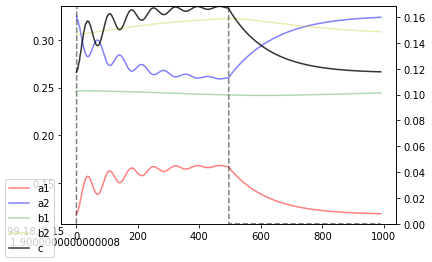

In [53]:
deltas = np.arange(1, 2, 0.1)
pulsewidths = np.arange(25,500,5)
peak_heights = np.zeros((len(deltas),len(pulsewidths)))
for i, delta in enumerate(deltas):
    for j, pulsewidth in enumerate(pulsewidths):
        deltaC1 = delta
        deltaC3 = deltaC1
        Hsys = (deltaC1-deltaC3)*a2*a2.dag() + deltaC3*c*c.dag()
        H = [Hsys+HintC1, [HintC3, seqC3]]

        rho0 = a1*a1.dag() + a2*a2.dag() + boltzmann*(b1*b1.dag() + b2*b2.dag())
        rho0 = rho0/rho0.tr()
        rho0 = steadystate(Hsys+HintC1, c_ops)
        e_ops = [a1*a1.dag(), a2*a2.dag(), b1*b1.dag(), b2*b2.dag(), c*c.dag()]

        tstart = 0
        pulsewidth = pulsewidth
        tmax = tstart + 2*pulsewidth
        pulse_args = {'tstart':tstart, 'pulsewidth':pulsewidth}
        t = np.linspace(0, tmax, 500)
        
        output = mesolve(H, rho0, t, c_ops=c_ops, e_ops=e_ops, args=pulse_args)
        cts = output.expect[0]
        
        peak_heights[i,j] = cts[np.argmin(np.abs(t-(tstart+pulsewidth)))+1]

    

    # if i%5==0:
    fig = plt.figure()
    ax = fig.gca()
    ax.plot(t, output.expect[0], '-r', label='a1', alpha=0.5)
    ax.plot(t, output.expect[1], '-b', label='a2', alpha=0.5)
    ax.plot(t, output.expect[2], '-g', label='b1', alpha=0.3)
    ax.plot(t, output.expect[3], '-y', label='b2', alpha=0.3)
    
    ax2 = ax.twinx()
    ax2.plot(t, cts, '-k', label='c', alpha=0.8)
    ax2.plot(t, seqC3(t, pulse_args)*max(np.amax(output.expect[0]),np.amax(output.expect[1])), '--k', alpha=0.5)
    ax2.set_ylim([0, np.amax(cts)])
    # ax2.set_yticks([])
    # ax2.set_yticklabels([])
    x = pulsewidths[:int(len(pulsewidths)/2)]
    y = peak_heights[0,:int(len(pulsewidths)/2)]
    try:
        ramsey_fit = lambda t, a, Omega, Gamma, phi, c: a*np.exp(-Gamma*t)*np.cos(Omega*t+phi) + c
        p0 = np.amax(y), (OmegaC1+OmegaC3)/(2*delta), 1/100, 0, y[-1]
        popt, pcov = cf(ramsey_fit, x, y, p0=p0)
        fig.text(0, 0.5*np.amax(y), f"{round(1/popt[2],2)}, {round(popt[1],2)}\n {delta}")
    except Exception as e:
        print(e)
    fig.legend(loc='lower left')
    plt.show()

99.17999306957988 413.7759268057771


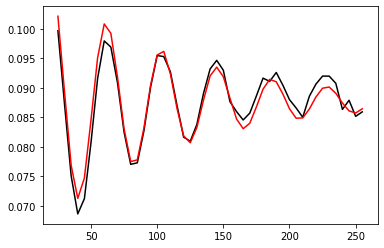

In [51]:
x = pulsewidths[:int(len(pulsewidths)/2)]
y = peak_heights[0,:int(len(pulsewidths)/2)]

ramsey_fit = lambda t, a, Omega, Gamma, phi, c: a*np.exp(-Gamma*t)*np.cos(Omega*t+phi) + c
p0 = np.amax(y), (OmegaC1+OmegaC3)/(2*delta), 1/100, 0, y[-1]
popt, pcov = cf(ramsey_fit, x, y, p0=p0)
plt.plot(x, y, '-k')
plt.plot(x, ramsey_fit(x, *popt), '-r')
print(1/popt[2], 1/(2*np.pi*OmegaC3**2*Gamma_pht/(4*delta**2)))

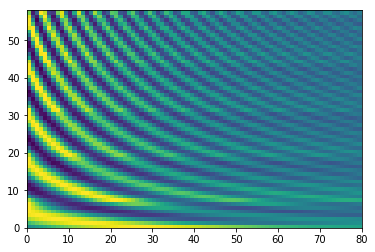

In [111]:
plt.pcolor(prep.maxabs_scale(peak_heights,axis=1))

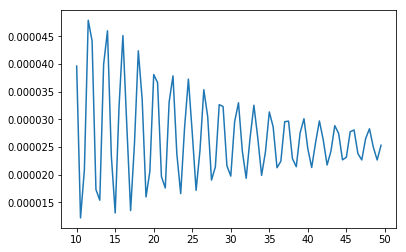

In [114]:
plt.plot(pulsewidths, peak_heights[-1,:])